In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

from utils.dataloader import *
from utils.GFP import *
from utils.torch_utils import *
from Groundtruth_model.CNN import *
from Groundtruth_model.ensemble import *
import warnings
warnings.filterwarnings("ignore")
from Oracle_model.oracle_from_CbAS import *
from tqdm import tqdm

## GFP deep mutational scanning datasets 

In [2]:
df = pd.read_csv('GFP_data/gfp_data.csv')
N_mutations = df["numAAMutations"].tolist()
X, _, X_seq = get_gfp_X_y_aa(df, large_only=True, ignore_stops=True, return_str=True)
unique_seq_idx = get_unique_X(X, return_idx=True)
unique_X_seq = get_unique_X(X)
# get number of AA mutation distribution
N_mutations_unique = [N_mutations[i] for i in unique_seq_idx]
unique_X_AA_seq = [X_seq[i] for i in unique_seq_idx]
diff_locus = []
WT =  unique_X_AA_seq[0]
for i in range(1, len(unique_X_AA_seq)):
    for locus in range(len(WT)):
        if WT[locus] != unique_X_AA_seq[i][locus]:
            diff_locus.append(locus)

Text(0.5, 1.0, 'substitutions along sequence')

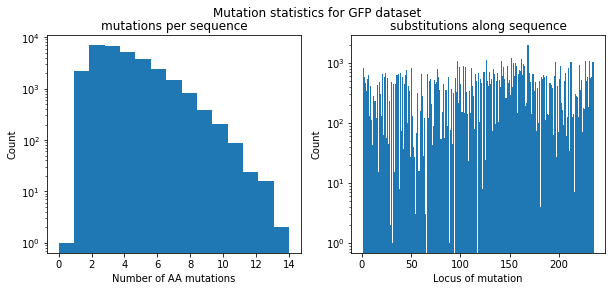

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Mutation statistics for GFP dataset')
ax1.hist(N_mutations_unique, bins=15, log=True)
ax1.set_ylabel('Count')
ax1.set_xlabel('Number of AA mutations')
ax1.set_title('mutations per sequence')

# Mutation statistics along sequence length
ax2.hist(diff_locus, bins=220, log=True)
ax2.set_ylabel('Count')
ax2.set_xlabel('Locus of mutation')
ax2.set_title('substitutions along sequence')

## Evaluate samples from GAN

In [2]:
import torch
import torch.optim as optim
from GAN_model.resnetGAN import *
from GAN_model.ProteoGAN import *
from utils.dataloader import *
from utils.torch_utils import *
from utils.metrics import *
from utils.pesudo_MSA import WT_GFP

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# GAN specific param
args_z_dim = 128; args_dim = 256;  args_epoch = 300
args_lr_Gen = 1e-4; args_lr_Disc = 8e-5;


In [3]:
# ========= set which data is used below: ========= #
train_data_type = 2
WT_seq = WT_GFP
# ================================================= #
# possible datasets for GAN:
run_names = ['ProteoGAN_GFP_MSA', 
             'ProteoGAN_GFP_mutational', 
             'ProteoGAN_GFP_pseudoMSA_D30']
args_run_name = run_names[train_data_type]
seq_len = len(WT_seq)
n_chars = 21 if args_run_name == run_names[0] else 20
from_MSA = True if args_run_name == run_names[0] else False

### Load GAN trained with different datasets

In [4]:
def load_checkpoints(discriminator, generator, optim_D, optim_G,
                     scheduler_D, scheduler_G, epoch):
    checkpoints = torch.load(
        os.path.join('checkpoints/'+args_run_name, 'epoch_{}'.format(epoch)))  
    discriminator.load_state_dict(checkpoints['disc_state_dict'])
    generator.load_state_dict(checkpoints['gen_state_dict'])
    optim_D.load_state_dict(checkpoints['optim_D_state_dict'])
    optim_G.load_state_dict(checkpoints['optim_G_state_dict'])
    scheduler_D.load_state_dict(checkpoints['scheduler_D_state_dict'])
    scheduler_G.load_state_dict(checkpoints['scheduler_G_state_dict'])
    return

def sample_generated(generator, run_name, n_seq=5000,
                     from_MSA = False):
    # random sampling n_seq noise, batched 100 noise at a time
    # return sampled n_seq sequences, also saving them to fasta file
    gen_seqs = []; max_batch_size = 100
    WT_encoding = onehot_encoder(WT_seq).argmax(-1).cpu().numpy()
    for _ in range(n_seq//max_batch_size):
        z = torch.randn(max_batch_size, args_z_dim, device=device)
        gen_probs = generator(z)
        gen_codings = [gen_prob.argmax(-1).cpu().numpy() for gen_prob in gen_probs]    
        if from_MSA:
            gen_codings = [np.where(gen_coding < 20, gen_coding, WT_encoding)
                               for gen_coding in gen_codings]
        batched_seq = [decode_one_seq(gen_coding) for gen_coding in gen_codings]
        gen_seqs += batched_seq
        torch.cuda.empty_cache()
    # saving seqs in fasta
    fasta_name = 'GFP_data/samples/' + run_name + '_nseq_' + str(n_seq) + '.fasta'
    outfile = open(fasta_name, 'w')
    for i, seq in enumerate(gen_seqs):
        seq_id = run_name + '_seq'+str(i)
        outfile.write('>' + seq_id + '\n')
        outfile.write(seq + '\n')
    return gen_seqs

In [7]:
seed_everything()
# init model and optimizer
Disc = Discriminator(args_dim, seq_len=seq_len, n_chars=n_chars).to(device)
Gen = Generator(args_dim, seq_len=seq_len, n_chars=n_chars, 
                z_dim=args_z_dim).to(device)
optim_disc = optim.Adam(filter(lambda p: p.requires_grad, Disc.parameters()),
                        lr=args_lr_Disc, betas=(0.0, 0.9))
optim_gen = optim.Adam(Gen.parameters(), lr=args_lr_Gen, betas=(0.0, 0.9))
# use an exponentially decaying learning rate
scheduler_d = optim.lr_scheduler.ExponentialLR(optim_disc, gamma=0.99)
scheduler_g = optim.lr_scheduler.ExponentialLR(optim_gen, gamma=0.99)

load_checkpoints(Disc, Gen, optim_disc, optim_gen, scheduler_d, scheduler_g, args_epoch-1)

In [8]:
gen_seqs = sample_generated(Gen, args_run_name, from_MSA=from_MSA, n_seq=20000)

### Obtain samples' fitness using ground truth models

In [2]:
run_names = ['ProteoGAN_GFP_MSA', 
             'ProteoGAN_GFP_mutational', 
             'ProteoGAN_GFP_pseudoMSA']
fasta_names = ['GFP_data/samples/' + run_name + '_nseq_' + \
    str(20000) + '.fasta' for run_name in run_names]
#fasta_names[0] = 'GFP_data/pseudo_MSA/GFP_pseudo_MSA_editDist15_0.fasta'
records = [list(SeqIO.parse(fasta_name, "fasta")) 
           for fasta_name in fasta_names]
# get unique sequences from sampled sequences
seqs_list = [list(set([str(record.seq) for record in record_i])) 
        for record_i in records]
# use these for downstream
seqs_onehot_list = [np.array([one_hot_encode_aa(seq.lower()) for seq in seqs])
                    for seqs in seqs_list]

In [3]:
# pass generated sequences into groundtruth model
groundtruth_models = load_GFP_ground_CNNs(n_models=8, train_epoch=300)
seqs_onehot_list_torch = [torch.from_numpy(seqs_onehot).to(torch.float32)
                          for seqs_onehot in seqs_onehot_list]
fitness_list = [ensemble_infer(groundtruth_models, seqs_onehot) for
                seqs_onehot in seqs_onehot_list_torch ]

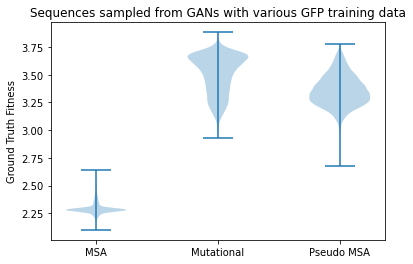

In [119]:
# form https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html 
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value
#########################################################################
sorted_fitness = [sorted(fitness) for fitness in fitness_list]
quarts = np.array([np.percentile(fitness, [25, 50, 75]) 
                        for fitness in sorted_fitness]) 
quartile1, medians, quartile3 = quarts[:,0], quarts[:,1], quarts[:,2]
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(sorted_fitness, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]
# plot
plt.figure(figsize=(6, 4))
plt.violinplot(sorted_fitness)
plt.title("Sequences sampled from GANs with various GFP training data")
plt.ylabel("Ground Truth Fitness")
plt.tick_params(direction='out')
labels = ['MSA', 'Mutational', 'Pseudo MSA']
_ = plt.xticks(np.arange(1, len(labels) + 1), labels=labels)


### LOW-ORDER ORACLES

In [122]:
ensemble_id = [5,5,5]; top_k = 96; train_sizes=[256, 512, 1024]
oracle0 = load_oracles( protein='GFP', suffix='Single', n_models=5, 
                        ensemble_id=ensemble_id[0], train_size=train_sizes[0]) 
oracle1 = load_oracles( protein='GFP', suffix='Single', n_models=5, 
                        ensemble_id=ensemble_id[1], train_size=train_sizes[1]) 
oracle2= load_oracles( protein='GFP', suffix='double', n_models=5, 
                        ensemble_id=ensemble_id[2], train_size=train_sizes[2]) 
 
oracles = [oracle0, oracle1, oracle2]

pred_fit_list = [[get_balaji_predictions(oracles_i, seqs_onehot)[0] 
           for seqs_onehot in seqs_onehot_list] for oracles_i in oracles]
top_k_ind_list = [[np.argpartition(pred, -top_k)[-top_k:] 
                  for pred in pred_fit_list_i] 
                  for pred_fit_list_i in pred_fit_list]
# record groundtruth fitness for the above selected sequences   
ground_topk_fit = [[fitness_list[i][top_k_ind_list_i[i]]
                      for i in range(len(fitness_list))] 
                   for top_k_ind_list_i in top_k_ind_list]
sorted_fitness = [[sorted(fitness) for fitness in ground_topk_fit_i]
                  for ground_topk_fit_i in ground_topk_fit]
quarts = [np.array([np.percentile(fitness, [25, 50, 75]) 
                        for fitness in sorted_fitness_i]) 
          for sorted_fitness_i in sorted_fitness]
quartile1, medians, quartile3 = \
    [quarts_i[:,0] for quarts_i in quarts], [quarts_i[:,1] for quarts_i in quarts], \
    [quarts_i[:,2] for quarts_i in quarts]

Text(0, 0.5, 'Ground Truth Fitness')

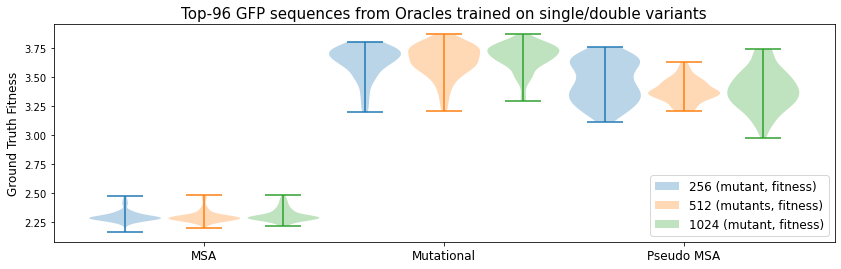

In [123]:
#plt.figure(figsize=(24, 4))
labels = ['MSA', 'Mutational', 'Pseudo MSA']
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(14, 4))
widths = 0.3
vp0 = ax.violinplot(sorted_fitness[0], positions=x-1.1*widths, widths=widths)
vp1 = ax.violinplot(sorted_fitness[1], positions=x, widths=widths)
vp2 = ax.violinplot(sorted_fitness[2], positions=x+1.1*widths, widths=widths)

#plt.violinplot(sorted_fitness[0])
plt.tick_params(direction='out')
_ = plt.xticks(np.arange(len(labels)), labels=labels, fontsize=12)
ax.legend([vp0['bodies'][0],vp1['bodies'][0], vp2['bodies'][0]], 
          ['256 (mutant, fitness)', '512 (mutants, fitness)', 
           '1024 (mutant, fitness)'], loc=4, fontsize=12)
ax.set_title("Top-" + str(top_k) + " GFP sequences from Oracles trained on " 
          + "single/double variants", fontsize=15)
ax.set_ylabel("Ground Truth Fitness", fontsize=12)

### HIGH-ORDER ORACLES

In [21]:
ensemble_id = [5,5,5]; top_k = 96; train_sizes=[256, 512, 1024]
oracle0 = load_oracles( protein='GFP', suffix='GFP', n_models=5, 
                        ensemble_id=ensemble_id[0], train_size=train_sizes[0]) 
oracle1 = load_oracles( protein='GFP', suffix='GFP', n_models=5, 
                        ensemble_id=ensemble_id[1], train_size=train_sizes[1]) 
oracle2= load_oracles( protein='GFP', suffix='GFP', n_models=5, 
                        ensemble_id=ensemble_id[2], train_size=train_sizes[2]) 
 
oracles = [oracle0, oracle1, oracle2]

pred_fit_list = [[get_balaji_predictions(oracles_i, seqs_onehot)[0] 
           for seqs_onehot in seqs_onehot_list] for oracles_i in oracles]
top_k_ind_list = [[np.argpartition(pred, -top_k)[-top_k:] 
                  for pred in pred_fit_list_i] 
                  for pred_fit_list_i in pred_fit_list]
# record groundtruth fitness for the above selected sequences   
ground_topk_fit = [[fitness_list[i][top_k_ind_list_i[i]]
                      for i in range(len(fitness_list))] 
                   for top_k_ind_list_i in top_k_ind_list]
sorted_fitness = [[sorted(fitness) for fitness in ground_topk_fit_i]
                  for ground_topk_fit_i in ground_topk_fit]
quarts = [np.array([np.percentile(fitness, [25, 50, 75]) 
                        for fitness in sorted_fitness_i]) 
          for sorted_fitness_i in sorted_fitness]
quartile1, medians, quartile3 = \
    [quarts_i[:,0] for quarts_i in quarts], [quarts_i[:,1] for quarts_i in quarts], \
    [quarts_i[:,2] for quarts_i in quarts]

Text(0, 0.5, 'Ground Truth Fitness')

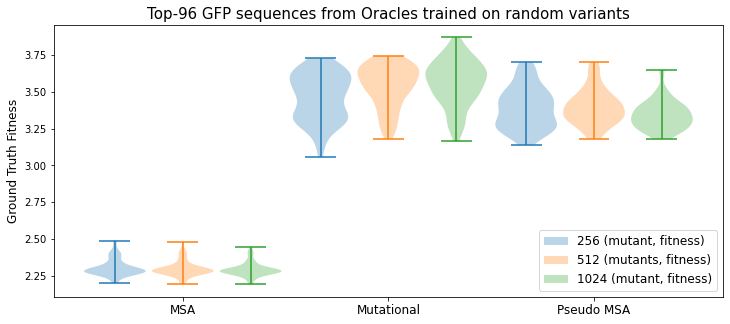

In [22]:
#plt.figure(figsize=(24, 4))
labels = ['MSA', 'Mutational', 'Pseudo MSA']
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(12, 5))
widths = 0.3
vp0 = ax.violinplot(sorted_fitness[0], positions=x-1.1*widths, widths=widths)
vp1 = ax.violinplot(sorted_fitness[1], positions=x, widths=widths)
vp2 = ax.violinplot(sorted_fitness[2], positions=x+1.1*widths, widths=widths)

#plt.violinplot(sorted_fitness[0])
plt.tick_params(direction='out')
_ = plt.xticks(np.arange(len(labels)), labels=labels, fontsize=12)
ax.legend([vp0['bodies'][0],vp1['bodies'][0], vp2['bodies'][0]], 
          ['256 (mutant, fitness)', '512 (mutants, fitness)', 
           '1024 (mutant, fitness)'], loc=4, fontsize=12)
ax.set_title("Top-" + str(top_k) + " GFP sequences from Oracles trained on " 
          + "random variants", fontsize=15)
ax.set_ylabel("Ground Truth Fitness", fontsize=12)

### Average Fitness across 10 experiments (LOW ORDER)

In [6]:
train_sizes=[96, 256, 512, 1024]
oracles_all = [[],[],[],[]]
for ensemble_id in range(10):
    oracles_all[0].append(load_oracles( protein='GFP', suffix='Single', n_models=5,
                            ensemble_id=ensemble_id, train_size=train_sizes[0])) 
    oracles_all[1].append(load_oracles( protein='GFP', suffix='Single', n_models=5, 
                            ensemble_id=ensemble_id, train_size=train_sizes[1])) 
    oracles_all[2].append(load_oracles( protein='GFP', suffix='Single', n_models=5, 
                            ensemble_id=ensemble_id, train_size=train_sizes[2])) 
    oracles_all[3].append(load_oracles( protein='GFP', suffix='double', n_models=5, 
                            ensemble_id=ensemble_id, train_size=train_sizes[3])) 

pred_fit_list = [[[get_balaji_predictions(oracles_i, seqs_onehot)[0] 
           for seqs_onehot in seqs_onehot_list] for oracles_i in tqdm(oracles)]
                 for oracles in tqdm(oracles_all)]

100%|██████████| 4/4 [03:47<00:00, 56.86s/it]


In [117]:
###################################################
top_k = 256
###################################################
top_k_ind_list = [[[np.argpartition(pred, -top_k)[-top_k:] 
                  for pred in pred_fit_list_ii] 
                  for pred_fit_list_ii in pred_fit_list_i]
                  for pred_fit_list_i in pred_fit_list]
ground_topk_fit = [[[fitness_list[i][top_k_ind_list_ii[i]]
                      for i in range(len(fitness_list))] 
                   for top_k_ind_list_ii in top_k_ind_list_i]
                   for top_k_ind_list_i in top_k_ind_list]
mean_fitness = [[[np.mean(fitness) for fitness in ground_topk_fit_ii]
                  for ground_topk_fit_ii in ground_topk_fit_i] 
                for ground_topk_fit_i in ground_topk_fit]
# average along the 10 experiments
MSA_mean_avg_fitness = [np.mean([mean_fitness_ii[0] for mean_fitness_ii in mean_fitness_i])
                    for mean_fitness_i in mean_fitness]
MSA_std_avg_fitness = [np.std([mean_fitness_ii[0] for mean_fitness_ii in mean_fitness_i])
                    for mean_fitness_i in mean_fitness]
mutational_mean_avg_fitness = [np.mean([mean_fitness_ii[1] for mean_fitness_ii in mean_fitness_i])
                    for mean_fitness_i in mean_fitness]
mutational_std_avg_fitness = [np.std([mean_fitness_ii[1] for mean_fitness_ii in mean_fitness_i])
                    for mean_fitness_i in mean_fitness]
pMSA_mean_avg_fitness = [np.mean([mean_fitness_ii[2] for mean_fitness_ii in mean_fitness_i])
                    for mean_fitness_i in mean_fitness]
pMSA_std_avg_fitness = [np.std([mean_fitness_ii[2] for mean_fitness_ii in mean_fitness_i])
                    for mean_fitness_i in mean_fitness]

Text(0.5, 1.0, 'Average fitness of top-256 GFP mutants across 10 experiments')

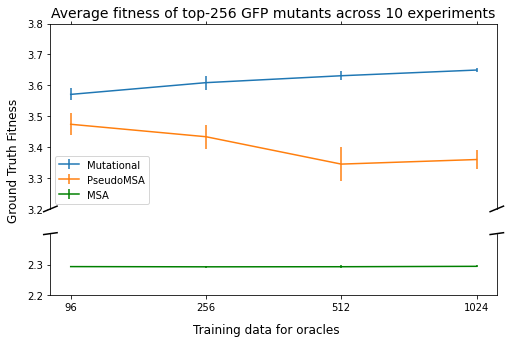

In [118]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 5), 
                              gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
x =  ["96", "256", "512", "1024"] 
ax2.errorbar(x, MSA_mean_avg_fitness, yerr=MSA_std_avg_fitness, label='MSA', color='green')
ax.errorbar(x, mutational_mean_avg_fitness, yerr=mutational_std_avg_fitness, label='Mutational')
ax.errorbar(x, pMSA_mean_avg_fitness, yerr=pMSA_std_avg_fitness, label='PseudoMSA')
ax.set_ylim(3.2, 3.8)
handles, labels = [(a + b) for a, b in zip(ax.get_legend_handles_labels(), 
                                           ax2.get_legend_handles_labels())] 
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax2.set_ylim(2.2, 2.4)
ax2.set_yticks(np.arange(2.2, 2.4, 0.1))
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
ax.legend(handles[:3], labels[:3], loc='lower left')
fig.supylabel("Ground Truth Fitness", x=0.05)
fig.supxlabel("Training data for oracles")
ax.set_title("Average fitness of top-" + str(top_k)+" GFP mutants across 10 experiments", 
             fontsize=14)